# Sieve Jobs
As I prepare to enter the Data Science industry, I thought it would be great practice to use some of the tools I've learned to apply to the job search itself. You could say this is an attempt to kill two birds with one stone.

## Objective
The objective of this study is to identify the entry level data science jobs by applying natural language processing library to the descriptions given in the job postings page of the linkedin website. At the time of this writing, there are over 155,000 jobs listed on the website in the Los Angeles area. While in terms of machine learning it might be beneficial to have a larger dataset, since I will be scraping the jobs individually, I will be limiting the jobs to those posted in the past week in the Los Angeles area that contains the keyword 'data' which still amounts to close to 5000 postings. 

I think the biggest difficulty in looking for jobs for most is that search results are inundated with jobs with ambiguous titles in some cases. In order to more easily separate the different types of jobs, I will use supervised machine learning algorithms to classify jobs that aren't explicitly labeled.

### I. Gather jobs data
For the purposes of this project, I am going to use the jobs section of the linkedin website. To keep the jobs shown as clean as possible (without any bias from my linkedin profile), I will be searching jobs as a guest and scraping all jobs posted within the past week. 

#### Import packages

In [115]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import pandas_profiling
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
%matplotlib inline
import seaborn as sns
from IPython.display import HTML
import numpy as np
import spacy
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/site-packages/en_core_web_sm -->
/usr/local/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


#### Utility Functions

In [2]:
########################### get webpage ############################
def simple_get(url):
    
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_resp(resp):
                return resp.content
            else:
                return None
            
    except RequestException as e:
        log_error(f'Error during requsts to {url}: {str(e)}')
        return None
    
def is_good_resp(resp):
    
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200
            and content_type is not None
            and content_type.find('html') > -1)

def log_error(e):
    
    print(e)

###################### parse with BeautifulSoup ##################### 

# parse html with BeautifulSoup
def bsparser(url):
    
    # get page
    raw_html = simple_get(url)

    # parse using BeautifulSoup
    parsed_html = BeautifulSoup(raw_html, 'html.parser')
    
    return parsed_html

##################### gather job info from page #####################

# scrape each job post page for relevant information
def sieve_page(html):
    
    # find all job listing titles
    job_list = html.find_all(class_='result-card job-result-card result-card--with-hover-state')
    #print(job_list)

    page_list = []
    
    if len(job_list) > 0:
        for job in job_list:
            global COUNT
            COUNT += 1
            print(f'Scraping job #{COUNT}\r', end='')
            
            title = job.find('h3').text
            company = job.find('h4').text
            location = job.find(class_='job-result-card__location').text
            link = job.find(class_='result-card__full-card-link').get('href')
            description = get_description(link)
            
            sieved_job = [title, company, location, link] + description
            page_list.append(sieved_job)
            
        #print(len(page_list))
        
        return page_list
    else:
        return None
    
#################### get full job description ######################  
    
# get details of the job posting
def get_description(url):
    details = []
    
    job_page = BeautifulSoup(simple_get(url), 'html.parser')
    level = job_page.find(class_='job-criteria__text job-criteria__text--criteria').text
    description = job_page.find(class_='description__text description__text--rich').text
    
    details = [level, description]
    
    return details

######################### keep count of jobs########################

COUNT = 0

###################### scrape all pages ############################

# takes the total number of jobs to scrape as the argument
def sieve_all_pages(url, desired_num_of_jobs):
    global COUNT
    COUNT = 0
    
    # start timer
    start = time.time()
    
    # used as a search parameter since each page only displays 25 posts
    list_pos = 0          
    sieved_list = []
    bad_urls = []
        
    while list_pos < desired_num_of_jobs:
        
        try:
            # get and parse page
            url += f'&start={list_pos}'
            html = bsparser(url)

            # use sieve_page function to gather relevant data and add to main list
            new_list = sieve_page(html)

            if len(new_list) > 0:
                sieved_list += new_list
                count = len(sieved_list)
            else:
                print(f'It took {time.time() - start} seconds to scrape {count} jobs.')
                break
                
        except:
            # handle error
            bad_urls.append(url)
            pass
        
        # change to new position
        list_pos += 25

    print(f'It took {time.time() - start} seconds to scrape {count} jobs.')

    return sieved_list

#### Scrape desired number of jobs

In [3]:
url = 'https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=data&location=Los%20Angeles%20Metropolitan%20Area&trk=guest_job_search_jobs-search-bar_search-submit&redirect=false&position=1&pageNum=0&f_TP=1%2C2'

# let's get scraping. This might take a few minutes.
my_jobs = sieve_all_pages(url, 5000)

Error during requsts to https://www.linkedin.com/jobs/view/data-analyst-int-at-atr-international-1609087910?refId=b9543c59-b4df-4799-9c89-5c38d7e385bd&position=16&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click: ('Connection broken: IncompleteRead(0 bytes read)', IncompleteRead(0 bytes read))
It took 2815.69699382782 seconds to scrape 4774 jobs.


### II. Build Dataframe and Cursory Exploration

#### Build dataframe

In [4]:
df = pd.DataFrame(my_jobs, columns=['title', 'company', 'location', 'link', 'level', 'description'])
df.sample(1)


title                     company             location  \
664  Data Analyst  AIDS Healthcare Foundation  Los Angeles, CA, US   

                                                  link        level  \
664  https://www.linkedin.com/jobs/view/data-analys...  Entry level   

                                           description  
664  Who We AreAMAZING INDIVIDUALS WORKING FOR POSI...

In [5]:
df.shape

(4774, 6)

In [6]:
profile = df.profile_report()

In [7]:
profile

#### Initial Analysis and Cleaning

What I am most interested in is whether the position is one that I have prepared for. I want to apply to positions that gives me the best chance of being hired. First, we need to filter out all non-data science jobs. But before we do that, just looking at the sample of job listings, the job titles don't seem to have any type of format. We need to fix that. Instead of changing the title itself, let's add a column that shows whether the job is a job in data science.

In [8]:
# create job type column and classify according to job title
df.loc[df['title'].str.contains('Data Scien|Machine Learning')==True, 'type'] = 'ds'
df.loc[df['title'].str.contains('Data Analys')==True, 'type'] = 'da'
df.loc[df['title'].str.contains('Data Scien|Machine Learning|Data Analys')==False, 'type'] = 'other'
df.sample(5)

title                      company  \
1988         Data Analyst                   GOAT Group   
897        Data Scientist                      Harnham   
2587         Data Analyst                   GOAT Group   
3765   Data Analyst - Int            ATR International   
2162  Python Data Analyst  Stand 8 Technology Services   

                           location  \
1988  Los Angeles Metropolitan Area   
897   Los Angeles Metropolitan Area   
2587  Los Angeles Metropolitan Area   
3765               Pasadena, CA, US   
2162       Greater Los Angeles Area   

                                                   link             level  \
1988  https://www.linkedin.com/jobs/view/data-analys...  Mid-Senior level   
897   https://www.linkedin.com/jobs/view/data-scient...  Mid-Senior level   
2587  https://www.linkedin.com/jobs/view/data-analys...  Mid-Senior level   
3765  https://www.linkedin.com/jobs/view/data-analys...       Entry level   
2162  https://www.linkedin.com/jobs/view/python-data...         Associate   

                                            description type  
1988  In this role you will:Use data to drive busine...   da  
897   MACHINE LEARNING ENGINEER $175,000 + BENEFITS ...   ds  
2587  In this role you will:Use data to drive busine...   da  
3765  ATR ID: ATR163651Job Level: AnalystJob Title: ...   da  
2162  Python Data Analyst 6 month contract in Los An...   da

Since the initial search was for any job that had the word 'data' in its title, if it's not explicitly labeled 'Data Scientist' or contain the phrase 'machine learning',  these will go into a third category 'other.' These job listings will have to be classified using our model.

In [9]:
# Data Science position count
counts = df['type'].value_counts()
counts

da       2290
other    1696
ds        788
Name: type, dtype: int64

This is a good sign. Since the way we split the two categories was just by checking to see whether the title contained certain words, at least we won't have to worry about jobs that have both titles, hence, making it easier for us to classify. 

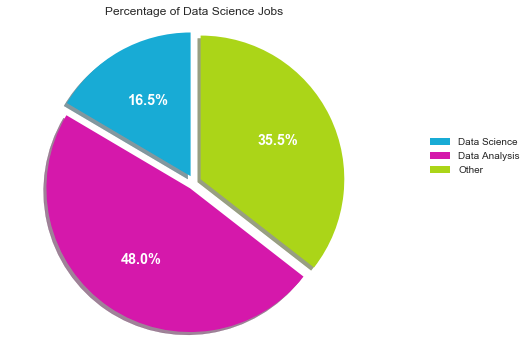

In [10]:
# plot pie chart
labels = ['Data Science', 'Data Analysis', 'Other']
# [ds count, da count, other]
sizes = [counts.ds, counts.da, counts.other]

f, ax = plt.subplots(figsize=(6, 6))
text_dict = {'color' : 'w', 
             'size'  : 'x-large', 
             'weight': 'bold'}
colors = ['#18ABD5', '#D518AB', '#ABD518']

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True,
       textprops=text_dict, colors=colors, explode=[0.05, 0.05, 0.05])
ax.axis('equal')

plt.title('Percentage of Data Science Jobs')
plt.legend(loc=4, bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.show()

Although the ratio could change from day to day (since we are only taking jobs listed in the past week), as of this last scrape, it looks like DS-titled job listings are outnumbered at a 3:1 ratio with Data Analysis jobs. So, we will randomly sample the data analysis jobs equalize it with the data science jobs.

Once I have balanced classes, what I will be doing is building an accurate model that differentiates the DS jobs from DA jobs and apply it to the other listings to classify them. This dataset actually works pretty nicely for that purpose. I can train the model on the rest of the data that is clearly classified as DS jobs and DA jobs which amounts to about 60% of the jobs listed. Then I can use that model to classify the other jobs. Sounds like a plan!

In [100]:
df.columns

Index(['title', 'company', 'location', 'link', 'level', 'description', 'ds',
       'da', 'parsed', 'filtered'],
      dtype='object')

#### Data Preparation for NLP
For this model, the target variable will be the is_ds column and I will be using the spacy library to parse the descriptions for each of the jobs. Then I am going to employ Bag of Words to create the features set on which the model will be trained.

In [11]:
df.iloc[3851].description

'The JobThe Data Engineer will be embedded within the WB Data team, focusing on and providing dedicated support to the Global Insights & Analytics team (GIA). The position will be closely aligned with their GIA counterparts to gather requirements, with oversight from the Executive Director, Consumer Intelligence & Engineering iterate, prototype, architect, test, and deliver high quality data intelligence solutions: data integration, data modeling, and analytics. The right candidate will execute test plans, perform quality reviews and support operations in an agile environment. The role will also provide technical advice, based on broad experience in the field of authority, to determine technical direction and strategy.The role requires a deep knowledge and hands-on experience working in large scale business intelligence and data platforms collaborating with key business partners to deliver customized data solutions that create business value. The role will also liaise closely with othe

In [12]:
nlp = spacy.load('en')

In [ ]:
#df = df.drop(columns=['parsed'])
#df.columns

In [13]:
# text cleaner
def clean_text(desc):
    desc = desc.lower()
    desc = re.sub('[\(\)]', '', desc)
    desc = re.sub('[\/\-\.]', ' ', desc)
    desc = ' '.join(desc.split())
    return desc

# parse each of the descriptions using spaCy
def spacify(desc):
    return nlp(clean_text(desc))

# filter out puctuation and stop words
def filter_text(parsed_text):
    filtered = []
    for token in parsed_text:
        if not token.is_punct and not token.is_stop:
            filtered.append(token.lemma_)
        
    return filtered 


In [14]:
# first parse each cleaned job description then filter lemmas
df['parsed'] = df.apply(lambda row: spacify(row['description']), axis=1)
df['filtered'] = df.apply(lambda row: filter_text(row['parsed']), axis=1)

Let's now sample the DA jobs to balance out the classes.

In [15]:
da_df = df[df['type'] == 'da'].sample(counts.ds)
da_df.sample(5)

title                      company  \
4436            Data Analyst                   GOAT Group   
35              Data Analyst                      System1   
3458            Data Analyst               Bluebeam, Inc.   
1487     Python Data Analyst  Stand 8 Technology Services   
1569  Marketing Data Analyst                   AuditBoard   

                           location  \
4436  Los Angeles Metropolitan Area   
35                   Venice, CA, US   
3458               Pasadena, CA, US   
1487       Greater Los Angeles Area   
1569  Los Angeles Metropolitan Area   

                                                   link             level  \
4436  https://www.linkedin.com/jobs/view/data-analys...  Mid-Senior level   
35    https://www.linkedin.com/jobs/view/data-analys...       Entry level   
3458  https://www.linkedin.com/jobs/view/data-analys...    Not Applicable   
1487  https://www.linkedin.com/jobs/view/python-data...         Associate   
1569  https://www.linkedin.com/jobs/view/marketing-d...  Mid-Senior level   

                                            description type  \
4436  In this role you will:Use data to drive busine...   da   
35    System1 is looking for a driven Data Analyst. ...   da   
3458  At Bluebeam, we empower people to advance the ...   da   
1487  Python Data Analyst 6 month contract in Los An...   da   
1569  AuditBoard Ranked #3 on Deloitte’s 2019 Fast 5...   da   

                                                 parsed  \
4436  (in, this, role, you, will, :, use, data, to, ...   
35    (system1, is, looking, for, a, driven, data, a...   
3458  (at, bluebeam, ,, we, empower, people, to, adv...   
1487  (python, data, analyst, 6, month, contract, in...   
1569  (auditboard, ranked, #, 3, on, deloitte, ’s, 2...   

                                               filtered  
4436  [role, use, datum, drive, business, decision, ...  
35    [system1, look, drive, datum, analyst, member,...  
3458  [bluebeam, empower, people, advance, way, worl...  
1487  [python, data, analyst, 6, month, contract, lo...  
1569  [auditboard, rank, 3, deloitte, 2019, fast, 50...

In [16]:
da_df.shape

(788, 9)

In [17]:
ds_df = df[df['type'] == 'ds']
ds_df.shape

(788, 9)

In [23]:
# combine the two dfs
bal_df = da_df.append(ds_df, ignore_index=True)
bal_df.sample(5)

title                         company  \
1374       Data Scientist                           Quibi   
36           Data Analyst                   Real Staffing   
285   Python Data Analyst     Stand 8 Technology Services   
66           Data Analyst  Cenergy International Services   
33           Data Analyst             Agile Tech Co., Ltd   

                                     location  \
1374                      Los Angeles, CA, US   
36    San Fernando, California, United States   
285                  Greater Los Angeles Area   
66                          Irwindale, CA, US   
33                        Los Angeles, CA, US   

                                                   link        level  \
1374  https://www.linkedin.com/jobs/view/data-scient...  Entry level   
36    https://www.linkedin.com/jobs/view/data-analys...    Associate   
285   https://www.linkedin.com/jobs/view/python-data...    Associate   
66    https://www.linkedin.com/jobs/view/data-analys...  Entry level   
33    https://www.linkedin.com/jobs/view/data-analys...  Entry level   

                                            description type  \
1374  What's Quibi?Launching next year, Quibi is the...   ds   
36    A world leading Medical Device Company in Sylm...   da   
285   Python Data Analyst 6 month contract in Los An...   da   
66    MS Office SkillsStrong written communication s...   da   
33    Looking for a Data AnalystJob DescriptionMust ...   da   

                                                 parsed  \
1374  (what, 's, quibi?launching, next, year, ,, qui...   
36    (a, world, leading, medical, device, company, ...   
285   (python, data, analyst, 6, month, contract, in...   
66    (ms, office, skillsstrong, written, communicat...   
33    (looking, for, a, data, analystjob, descriptio...   

                                               filtered  
1374  [quibi?launche, year, quibi, entertainment, pl...  
36    [world, lead, medical, device, company, sylmar...  
285   [python, data, analyst, 6, month, contract, lo...  
66    [ms, office, skillsstrong, write, communicatio...  
33    [look, data, analystjob, descriptionmust, manu...

In [24]:
bal_df.shape

(1576, 9)

#### Bag of Words
Now let's create a bag of words consisting of the most frequently used words.

In [25]:
# get most common words
def bag_of_words(text, size):
    all_words = []
    rows = []
    words_df = pd.DataFrame(columns=['checkpoint', 'word', 'count'])

    for i, doc in enumerate(text.tolist()):
        
        # create a dataframe with word counts at an interval
        if i > 0 and i % 25 == 0 or i == len(text.tolist()):  # checkpoint every 25 rows
            top_words = Counter(all_words).most_common(25)
            
            for item in top_words:
                rows.append([i, item[0], item[1]])
                
        else:
            pass
        
        # bag of words
        for token in doc:
            if not token.is_punct and not token.is_stop:
                all_words.append(token.lemma_)
        
        bow = [item[0] for item in Counter(all_words).most_common(size)]
        
    return rows, bow   


In [26]:
# let's get top 500 and top 1000 to see which gets us better models
top500, top500_bow = bag_of_words(bal_df.parsed, 500)
#top1000_df, top1000_bow = bag_of_words(df.parsed, 1000)

In [27]:
# create dataframe with the counts checkpoint data
word_df = pd.DataFrame(top500, columns=['checkpoint', 'word', 'count'])
#word_df.loc[100:200]

Let's see the word counts of the top 25 words at each checkpoint.

In [28]:
# assign colors to each word
colors = []
for i in range(200):
    colors.append(np.random.rand(3,))
        
# assign colors
c_dict = dict(zip(top500_bow[:200], colors))
#print(c_dict)

In [30]:
# function for animator
def draw_barchart(checkpoint):
    
    # get corresponding data for each checkpoint
    cp_df = word_df[word_df['checkpoint']==checkpoint].sort_values(by='count', ascending=True)
    
    # clear axis
    ax.clear()
    
    # draw new plot
    ax.barh(cp_df['word'], cp_df['count'], color=[c_dict[x] for x in cp_df['word']], alpha=0.5)
    
    dx = cp_df['count'].max()/200
    
    # iterate over the values to plot labels and values
    for i, (count, word) in enumerate(zip(cp_df['count'], cp_df['word'])):
        ax.text(count-dx, i, word, ha='right', va='center', fontsize=15, weight=1000)
        ax.text(count+dx, i, count, ha='left', va='center', fontsize=15)
    
    ax.xaxis.set_ticks_position('top')
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.text(0, 1.05, 'Top 25 words used by count', transform=ax.transAxes, size=25, weight=1000)
    ax.text(1, 0.4, f"Checkpoint: {checkpoint}", transform=ax.transAxes, size=46, ha='right')
    ax.grid(b=True, which='major', axis='x', color='grey')
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    plt.close()

#draw_barchart(200)

# animate
f, ax = plt.subplots(figsize=(14, 12))
animator = animation.FuncAnimation(f, draw_barchart, frames=range(25, bal_df.shape[0], 25),
                                   interval=400)
HTML(animator.to_jshtml())



Well that wasn't much of a race, per se. Top 10 words pretty much stay the same understandably. Now let's go ahead and create the feature set using the bag of words.

### III. Feature Engineering

In [32]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(df, common_words):
    
    # start timer
    start = time.time()
    
    # Scaffold the data frame and initialize counts to zero.
    this_df = pd.DataFrame(columns=common_words)
    this_df['description'] = df['parsed']
    this_df['type'] = df['type']
    this_df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['description']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in nlp(sentence)
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            this_df.loc[i, word] += 1

        # This counter is just to make sure the kernel didn't hang.
        if i % 100 == 0:
            print(f"Processing row {i}\r", end='')
        
    print(f'Time elapsed: {(time.time()-start):0.2f}s')

    return this_df

In [33]:
# get new df with only the dependent and independent variables
feature_df = bow_features(bal_df, top500_bow)    # this should take a while

Time elapsed: 1231.34s


In [34]:
feature_df.sample(5)

datum experience work data business team learning machine analysis skill  \
1416    13          5    7    3        4    4        4       4        4     3   
1098     2          6    5    0        3    1        4       5        1     3   
1550    13          8    5    2        5    3        4       2        2     3   
314      3          0    1    1        1    4        0       0        0     1   
897      5          3    1    3        3    3        2       4        1     1   

      ... career peer affirmative policy operate proud developer capture  \
1416  ...      1    0           0      2       0     0         0       0   
1098  ...      0    0           0      0       0     0         0       0   
1550  ...      0    0           0      0       0     0         0       0   
314   ...      0    0           0      0       0     0         0       0   
897   ...      0    0           0      0       0     0         0       0   

                                            description type  
1416  (job, detailsresponsibilitieswork, with, busin...   ds  
1098  (machine, learning, engineer, $, 175,000, +, b...   ds  
1550  (tamara, mellon, ,, co, founder, of, jimmy, ch...   ds  
314   (system1, is, looking, for, a, driven, data, a...   da  
897   (what, 's, quibi?launching, next, year, ,, qui...   ds  

[5 rows x 502 columns]

That looks good. Now for some modeling, finally!

### IV. Train Models

#### Training and Testing data split
If you recall, we were going to model the data using job listings that were clearly DS (Data Science) or DA jobs. Then we are going to use that trained model on classifying the 'other' jobs.

In [35]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

X = feature_df.drop(['type', 'description'], axis=1)
y = feature_df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')


Train set size: (945, 500)
Test set size: (631, 500)


#### Modeling function

In [36]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# I'm going to be repeating a lot of the fitting and predicting and scoring.
# Let's build a function, albeit a very limited one that does not take in additional
# hyperparameters
def classify(alg, X, y):
        
    # data formatting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=26)
    
    start = time.time()
    
    if alg == 'naive_bayes':
        clf = BernoulliNB()
        
    elif alg == 'logistic_regression':
        clf = LogisticRegression(solver='lbfgs') 
        
    elif alg == 'knn':
        clf = KNeighborsClassifier(n_neighbors=2) 
        
    elif alg == 'random_forest':
        clf = ensemble.RandomForestClassifier() 
        
    elif alg == 'svc':
        clf = SVC(gamma='auto') 
        
    elif alg == 'gradient_boost':
        clf = ensemble.GradientBoostingClassifier() 
        
    clf.fit(X_train, y_train)
    train_score = float(f'{clf.score(X_train, y_train):.4f}')
    y_pred = clf.predict(X_test)
    c_mat = confusion_matrix(y_test, y_pred, labels=['ds', 'da'])
    test_score = float(f'{clf.score(X_test, y_test):.4f}')
    elapsed = float(f'{time.time() - start:.4f}')
    
    return [train_score, test_score, elapsed], c_mat, clf
        

#### Naive-Bayes

In [37]:
nb_stats, nb_cmat, nb = classify('naive_bayes', X, y)
rows = []
rows.append(nb_stats)
rows

[[1.0, 0.9984, 0.0775]]

#### Rinse and Repeat (Logistic Regression, KNN, Random Forest, SVM, Gradient Boost)

In [38]:
lr_stats, lr_cmat, lr = classify('logistic_regression', X, y)
rows.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X, y)
rows.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X, y)
rows.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X, y)
rows.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X, y)
rows.append(gb_stats)

rows

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[1.0, 0.9984, 0.0775],
 [1.0, 0.9984, 0.0804],
 [0.9979, 0.9937, 0.3506],
 [1.0, 0.9937, 0.0575],
 [1.0, 0.9984, 0.1367],
 [1.0, 0.9984, 0.4282]]

In [39]:
# results dataframe
res_df = pd.DataFrame(rows,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res_df

train_score  test_score  time_elapsed
Naive-Bayes               1.0000      0.9984        0.0775
Logistic Regression       1.0000      0.9984        0.0804
Random Forest             0.9979      0.9937        0.3506
KNN                       1.0000      0.9937        0.0575
SVM                       1.0000      0.9984        0.1367
Gradient Boost            1.0000      0.9984        0.4282

It's quite obvious that the bag of words with top 500 words may be overkill, especially since it takes a long time for that list to be created. Let's see if we can get good accuracy with a smaller bag. Since the bag of words is already ordered most frequent to least frequent, we can just use a subset of the top 500 list.

In [40]:
top250_bow = top500_bow[:250]
top100_bow = top500_bow[:100]
top25_bow = top500_bow[:25]

#### 250-word BOW

In [41]:
ftr_250_df = bow_features(bal_df, top250_bow)    # this should take a while

Time elapsed: 468.49s


In [42]:
y250 = ftr_250_df['type']
X250 = ftr_250_df.drop(['type', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X250, y250, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')

X_train.sample()

Train set size: (945, 250)
Test set size: (631, 250)


datum experience work data business team learning machine analysis skill  \
25     7          2    4    5        5    6        0       0        4     3   

    ... viacomcbs share building grow brand google veteran familiarity cloud  \
25  ...         0     0        0    0     0      0       0           0     1   

   test  
25    1  

[1 rows x 250 columns]

In [43]:
rows250 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X250, y250)
rows250.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X250, y250)
rows250.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X250, y250)
rows250.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X250, y250)
rows250.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X250, y250)
rows250.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X250, y250)
rows250.append(gb_stats)

rows250

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.9989, 0.9984, 0.0513],
 [1.0, 0.9984, 0.0432],
 [0.9979, 0.9937, 0.2004],
 [1.0, 0.9968, 0.0339],
 [1.0, 0.9984, 0.0664],
 [1.0, 0.9984, 0.2307]]

In [44]:
# results dataframe
res250_df = pd.DataFrame(rows250,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res250_df

train_score  test_score  time_elapsed
Naive-Bayes               0.9989      0.9984        0.0513
Logistic Regression       1.0000      0.9984        0.0432
Random Forest             0.9979      0.9937        0.2004
KNN                       1.0000      0.9968        0.0339
SVM                       1.0000      0.9984        0.0664
Gradient Boost            1.0000      0.9984        0.2307

#### 100-word BOW

In [45]:
ftr_100_df = bow_features(bal_df, top100_bow)    # this should take a while

Time elapsed: 176.46s


In [46]:
y100 = ftr_100_df['type']
X100 = ftr_100_df.drop(['type', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X100, y100, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')

#X_train.columns


Train set size: (945, 100)
Test set size: (631, 100)


In [47]:
rows100 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X100, y100)
rows100.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X100, y100)
rows100.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X100, y100)
rows100.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X100, y100)
rows100.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X100, y100)
rows100.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X100, y100)
rows100.append(gb_stats)

rows100

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.9979, 0.9984, 0.0259],
 [1.0, 0.9984, 0.0367],
 [0.9968, 0.9968, 0.1127],
 [1.0, 1.0, 0.0234],
 [1.0, 0.9984, 0.0289],
 [1.0, 0.9984, 0.1176]]

In [48]:
# results dataframe
res100_df = pd.DataFrame(rows100,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res100_df

train_score  test_score  time_elapsed
Naive-Bayes               0.9979      0.9984        0.0259
Logistic Regression       1.0000      0.9984        0.0367
Random Forest             0.9968      0.9968        0.1127
KNN                       1.0000      1.0000        0.0234
SVM                       1.0000      0.9984        0.0289
Gradient Boost            1.0000      0.9984        0.1176

#### 25-word BOW

In [49]:
ftr_25_df = bow_features(bal_df, top25_bow)    # this should take a while

Time elapsed: 101.83s


In [50]:
y25 = ftr_25_df['type']
X25 = ftr_25_df.drop(['type', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X25, y25, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')


Train set size: (945, 25)
Test set size: (631, 25)


In [51]:
rows25 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X25, y25)
rows25.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X25, y25)
rows25.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X25, y25)
rows25.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X25, y25)
rows25.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X25, y25)
rows25.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X25, y25)
rows25.append(gb_stats)

rows25

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.9164, 0.9049, 0.0154],
 [1.0, 0.9984, 0.0267],
 [0.9979, 0.9984, 0.0729],
 [1.0, 0.9968, 0.018],
 [1.0, 0.9968, 0.0134],
 [1.0, 0.9984, 0.0584]]

In [52]:
# results dataframe
res25_df = pd.DataFrame(rows25,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res25_df

train_score  test_score  time_elapsed
Naive-Bayes               0.9164      0.9049        0.0154
Logistic Regression       1.0000      0.9984        0.0267
Random Forest             0.9979      0.9984        0.0729
KNN                       1.0000      0.9968        0.0180
SVM                       1.0000      0.9968        0.0134
Gradient Boost            1.0000      0.9984        0.0584

At this point, let's plot a correlation matrix to see if certain word pairs are more highly correlated.

#### Correlation Matrix with 25 BoW

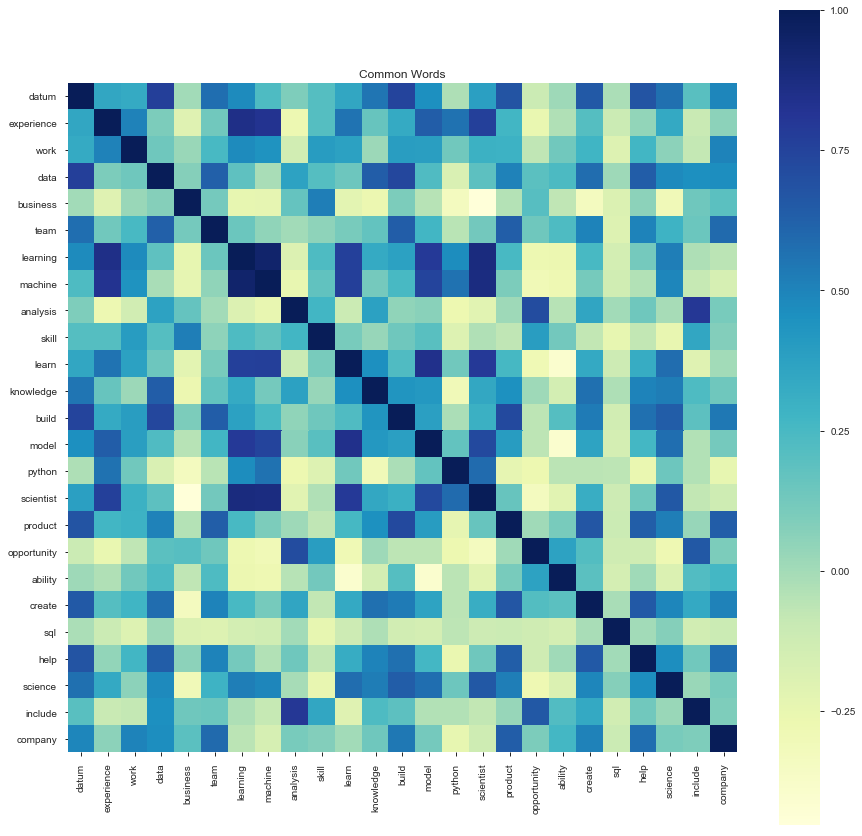

In [53]:
corr_mat = X25.astype(int).corr()

plt.subplots(figsize=(15, 15))
sns.heatmap(data=corr_mat, cmap='YlGnBu', square=True)
plt.title('Common Words')
plt.show()

Let's remove words that have a high correlation with more than 5 words.
- datum
- experience
- team
- learn
- build
- science
- help
- create

In [54]:
columns = ['datum', 'experience', 'team', 'learn', 'build', 'science', 'help', 'create']
X17 = X25.drop(columns=columns)


In [55]:
rows17 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X17, y25)
rows17.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X17, y25)
rows17.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X17, y25)
rows17.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X17, y25)
rows17.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X17, y25)
rows17.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X17, y25)
rows17.append(gb_stats)

rows17

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.9164, 0.9049, 0.0141],
 [0.9989, 0.9984, 0.0245],
 [0.9979, 0.9968, 0.0687],
 [1.0, 0.9984, 0.0172],
 [1.0, 0.9984, 0.0116],
 [1.0, 0.9984, 0.0477]]

#### Evaluation

In [56]:
# create a results list for each of the models
nb_res, lr_res, rf_res, knn_res, svm_res, gb_res = ([] for i in range(6))
res_list = [rows, rows250, rows100, rows25, rows17]

for res in res_list:
    nb_res.append(res[0])
    lr_res.append(res[1])
    rf_res.append(res[2])
    knn_res.append(res[3])
    svm_res.append(res[4])
    gb_res.append(res[5])
    

In [57]:
# Naive-Bayes
nb_df = pd.DataFrame(nb_res, columns=['train_score', 'test_score', 'time_elapsed'])
nb_df['bow'] = [500, 250, 100, 25, 17]
nb_df

train_score  test_score  time_elapsed  bow
0       1.0000      0.9984        0.0775  500
1       0.9989      0.9984        0.0513  250
2       0.9979      0.9984        0.0259  100
3       0.9164      0.9049        0.0154   25
4       0.9164      0.9049        0.0141   17

In [58]:
# Logistic Regression
lr_df = pd.DataFrame(lr_res, columns=['train_score', 'test_score', 'time_elapsed'])
lr_df['bow'] = [500, 250, 100, 25, 17]
lr_df

train_score  test_score  time_elapsed  bow
0       1.0000      0.9984        0.0804  500
1       1.0000      0.9984        0.0432  250
2       1.0000      0.9984        0.0367  100
3       1.0000      0.9984        0.0267   25
4       0.9989      0.9984        0.0245   17

In [59]:
# Random Forest
rf_df = pd.DataFrame(rf_res, columns=['train_score', 'test_score', 'time_elapsed'])
rf_df['bow'] = [500, 250, 100, 25, 17]
rf_df

train_score  test_score  time_elapsed  bow
0       0.9979      0.9937        0.3506  500
1       0.9979      0.9937        0.2004  250
2       0.9968      0.9968        0.1127  100
3       0.9979      0.9984        0.0729   25
4       0.9979      0.9968        0.0687   17

In [60]:
# K-Nearest Neighbor
knn_df = pd.DataFrame(knn_res, columns=['train_score', 'test_score', 'time_elapsed'])
knn_df['bow'] = [500, 250, 100, 25, 17]
knn_df

train_score  test_score  time_elapsed  bow
0          1.0      0.9937        0.0575  500
1          1.0      0.9968        0.0339  250
2          1.0      1.0000        0.0234  100
3          1.0      0.9968        0.0180   25
4          1.0      0.9984        0.0172   17

In [61]:
# Support Vector Machine
svm_df = pd.DataFrame(svm_res, columns=['train_score', 'test_score', 'time_elapsed'])
svm_df['bow'] = [500, 250, 100, 25, 17]
svm_df

train_score  test_score  time_elapsed  bow
0          1.0      0.9984        0.1367  500
1          1.0      0.9984        0.0664  250
2          1.0      0.9984        0.0289  100
3          1.0      0.9968        0.0134   25
4          1.0      0.9984        0.0116   17

In [62]:
# Gradient Boosting
gb_df = pd.DataFrame(gb_res, columns=['train_score', 'test_score', 'time_elapsed'])
gb_df['bow'] = [500, 250, 100, 25, 17]
gb_df

train_score  test_score  time_elapsed  bow
0          1.0      0.9984        0.4282  500
1          1.0      0.9984        0.2307  250
2          1.0      0.9984        0.1176  100
3          1.0      0.9984        0.0584   25
4          1.0      0.9984        0.0477   17

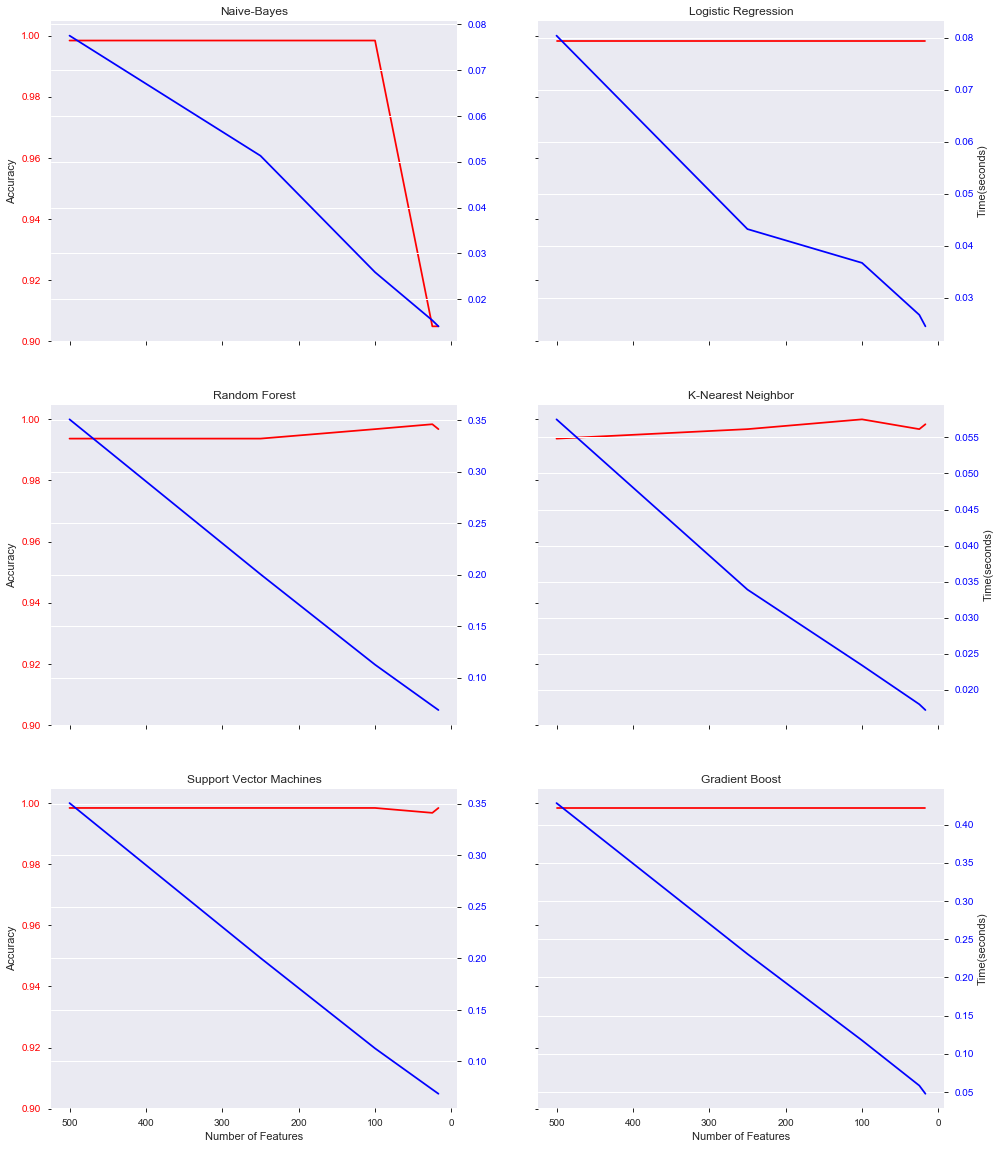

In [63]:
f, ax = plt.subplots(3, 2, figsize=(16, 20), sharex=True, sharey=True)

# Naive-Bayes
ax1 = ax[0, 0]
ax1.plot(nb_df['bow'], nb_df['test_score'], c='r')
ax1.tick_params(axis='y', labelcolor='r')

ax1a = ax1.twinx()
ax1a.plot(nb_df['bow'], nb_df['time_elapsed'], c='b')
ax1a.tick_params(axis='y', labelcolor='b')

ax1.set_ylabel('Accuracy')
ax1.invert_xaxis()
ax1.grid()
ax1.set_title('Naive-Bayes')

# Logistic Regression
ax2 = ax[0, 1]
ax2.plot(lr_df['bow'], lr_df['test_score'], c='r')
ax2.tick_params(axis='y', labelcolor='r')

ax2a = ax2.twinx()
ax2a.plot(lr_df['bow'], lr_df['time_elapsed'], c='b')
ax2a.tick_params(axis='y', labelcolor='b')
ax2a.set_ylabel('Time(seconds)')

ax2.grid()
ax2.set_title('Logistic Regression')

# Random Forest
ax3 = ax[1, 0]
ax3.plot(rf_df['bow'], rf_df['test_score'], c='r')
ax3.tick_params(axis='y', labelcolor='r')

ax3a = ax3.twinx()
ax3a.plot(rf_df['bow'], rf_df['time_elapsed'], c='b')
ax3a.tick_params(axis='y', labelcolor='b')

ax3.set_ylabel('Accuracy')
ax3.grid()
ax3.set_title('Random Forest')

# K-Nearest Neighbors
ax4 = ax[1, 1]
ax4.plot(knn_df['bow'], knn_df['test_score'], c='r')
ax4.tick_params(axis='y', labelcolor='r')

ax4a = ax4.twinx()
ax4a.plot(knn_df['bow'], knn_df['time_elapsed'], c='b')
ax4a.tick_params(axis='y', labelcolor='b')
ax4a.set_ylabel('Time(seconds)')

#ax4.invert_xaxis()
ax4.grid()
ax4.set_title('K-Nearest Neighbor')

# Support Vector Machines
ax5 = ax[2, 0]
ax5.plot(svm_df['bow'], svm_df['test_score'], c='r')
ax5.tick_params(axis='y', labelcolor='r')

ax5a = ax5.twinx()
ax5a.plot(rf_df['bow'], rf_df['time_elapsed'], c='b')
ax5a.tick_params(axis='y', labelcolor='b')

#ax5.invert_xaxis()
ax5.grid()
ax5.set_xlabel('Number of Features')
ax5.set_ylabel('Accuracy')
ax5.set_title('Support Vector Machines')

# Gradient Boost
ax6 = ax[2, 1]
ax6.plot(gb_df['bow'], gb_df['test_score'], c='r')
ax6.tick_params(axis='y', labelcolor='r')

ax6a = ax6.twinx()
ax6a.plot(gb_df['bow'], gb_df['time_elapsed'], c='b')
ax6a.tick_params(axis='y', labelcolor='b')
ax6a.set_ylabel('Time(seconds)')

#ax6.invert_xaxis()
ax6.grid()
ax6.set_xlabel('Number of Features')
ax6.set_title('Gradient Boost')

plt.show()

Looking at these plots, as the size of the bag of words decreases, naive-bayes, logistic regression, knn, and gradient boosting models all decrease in accuracy while the random forest and support vector classifiers slightly increase. Let's evaluate further.

In [64]:
# evaluation function
def evaluate(c_mat):
    # tp / (tp + fp)
    precision = c_mat[0, 0] / (c_mat[0, 0] + c_mat[1, 0])
    
    # tn / (tn + fn)
    recall = c_mat[1, 1] / (c_mat[1, 1] + c_mat[0, 1])
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1

In [65]:
# calculate scores
nb_prec, nb_rec, nb_f1 = evaluate(nb_cmat)
lr_prec, lr_rec, lr_f1 = evaluate(lr_cmat)
rf_prec, rf_rec, rf_f1 = evaluate(rf_cmat)
knn_prec, knn_rec, knn_f1 = evaluate(knn_cmat)
svm_prec, svm_rec, svm_f1 = evaluate(svm_cmat)
gb_prec, gb_rec, gb_f1 = evaluate(gb_cmat)

In [66]:
# let's start with the confusion matrices
print(f'Naive-Bayes:\n{nb_cmat}')
print(f'  Precision:{nb_prec}\n  Recall:   {nb_rec}\n  f1-score: {nb_f1}\n')

print(f'Logistic regression:\n{lr_cmat}')
print(f'  Precision:{lr_prec}\n  Recall:   {lr_rec}\n  f1-score: {lr_f1}\n')

print(f'Random forest:\n{rf_cmat}')
print(f'  Precision:{rf_prec}\n  Recall:   {rf_rec}\n  f1-score: {rf_f1}\n')

print(f'KNN:\n{knn_cmat}')
print(f'  Precision:{knn_prec}\n  Recall:   {knn_rec}\n  f1-score: {knn_f1}\n')

print(f'SVM:\n{svm_cmat}')
print(f'  Precision:{svm_prec}\n  Recall:   {svm_rec}\n  f1-score: {svm_f1}\n')

print(f'Gradient boost:\n{gb_cmat}')
print(f'  Precision:{gb_prec}\n  Recall:   {gb_rec}\n  f1-score: {gb_f1}\n')


Naive-Bayes:
[[256  60]
 [  0 315]]
  Precision:1.0
  Recall:   0.84
  f1-score: 0.9130434782608696

Logistic regression:
[[315   1]
 [  0 315]]
  Precision:1.0
  Recall:   0.9968354430379747
  f1-score: 0.9984152139461173

Random forest:
[[315   1]
 [  0 315]]
  Precision:1.0
  Recall:   0.9968354430379747
  f1-score: 0.9984152139461173

KNN:
[[314   2]
 [  0 315]]
  Precision:1.0
  Recall:   0.9936908517350158
  f1-score: 0.9968354430379747

SVM:
[[315   1]
 [  0 315]]
  Precision:1.0
  Recall:   0.9968354430379747
  f1-score: 0.9984152139461173

Gradient boost:
[[315   1]
 [  0 315]]
  Precision:1.0
  Recall:   0.9968354430379747
  f1-score: 0.9984152139461173



For our purposes, we want to minimize the false negatives, or jobs that are DS jobs but misclassified. That is to say, we want high recall numbers. But since all 6 models give us a perfect recall and f-1 score, let's use the model that gives us explainability. We have two models that fit this criteria but I'll go with random forest since it is most consistently good.

#### Gradient Boosting Classifier Evaluation

In [67]:
# feature importance
fi = gb.feature_importances_
words = X17.columns
important_words = list(zip(fi, words))
important_words

[(0.0, 'work'),
 (0.004221944354814557, 'data'),
 (0.0, 'business'),
 (6.713090316622889e-06, 'learning'),
 (0.7124348419192734, 'machine'),
 (0.2833365006355953, 'analysis'),
 (0.0, 'skill'),
 (0.0, 'knowledge'),
 (0.0, 'model'),
 (0.0, 'python'),
 (0.0, 'scientist'),
 (0.0, 'product'),
 (0.0, 'opportunity'),
 (0.0, 'ability'),
 (0.0, 'sql'),
 (0.0, 'include'),
 (0.0, 'company')]

### V. Make Predictions

So now that we have a model, let's apply the 'other' jobs to see how many can actually be classified as DS jobs.

In [68]:
# "Other" jobs
other_df = df[df['type'] == 'other']
other_df.reset_index(drop=True, inplace=True)
other_df.head(5)

title                     company  \
0  Data Operations Analyst                      Optomi   
1            Data Engineer  Warner Bros. Entertainment   
2            Data Engineer                     Clutter   
3     Senior Data Engineer          Signify Technology   
4            Data Engineer                      Prosum   

                                        location  \
0        Santa Monica, California, United States   
1                                Burbank, CA, US   
2                            Los Angeles, CA, US   
3        Santa Monica, California, United States   
4  91364, Los Angeles, California, United States   

                                                link             level  \
0  https://www.linkedin.com/jobs/view/data-operat...  Mid-Senior level   
1  https://www.linkedin.com/jobs/view/data-engine...         Associate   
2  https://www.linkedin.com/jobs/view/data-engine...       Entry level   
3  https://www.linkedin.com/jobs/view/senior-data...  Mid-Senior level   
4  https://www.linkedin.com/jobs/view/data-engine...  Mid-Senior level   

                                         description   type  \
0  Data Operations Analyst - Santa Monica, CA    ...  other   
1  The JobThe Data Engineer will be embedded with...  other   
2  Clutter is an on-demand storage and technology...  other   
3  Senior Data Engineer contractor   Would you li...  other   
4  We are seeking a Senior ETL Developer to join ...  other   

                                              parsed  \
0  (data, operations, analyst, santa, monica, ,, ...   
1  (the, jobthe, data, engineer, will, be, embedd...   
2  (clutter, is, an, on, demand, storage, and, te...   
3  (senior, data, engineer, contractor, would, yo...   
4  (we, are, seeking, a, senior, etl, developer, ...   

                                            filtered  
0  [data, operation, analyst, santa, monica, want...  
1  [jobthe, datum, engineer, embed, wb, data, tea...  
2  [clutter, demand, storage, technology, company...  
3  [senior, datum, engineer, contractor, like, ch...  
4  [seek, senior, etl, developer, join, team, see...

In [69]:
other_ftr_17_df = bow_features(other_df, top25_bow)    # this should take a while

Time elapsed: 102.10s


In [70]:
other_ftr_17_df = other_ftr_17_df.drop(columns=columns)

other_ftr_17_df.sample(5)

work data business learning machine analysis skill knowledge model  \
1247    2    2        6        1       1        0     3         2     1   
936     5    1        2        0       0        0     1         1     1   
1333    1    3        7        0       0        1     0         3     0   
598     2    2        4        1       1        0     1         0     0   
1254    5    1        2        0       1        2     4         0     0   

     python scientist product opportunity ability sql include company  \
1247      0         0       2           0       0   0       1       2   
936       0         0       1           0       0   0       1       2   
1333      0         0       2           1       0   0       1       0   
598       0         1       3           0       1   0       2       1   
1254      0         0       0           0       2   0       0       1   

                                            description   type  
1247  (fabfitfun, is, seeking, a, data, architect, w...  other  
936   (there, 's, something, in, the, water, at, chr...  other  
1333  (the, jobthe, data, engineer, will, be, embedd...  other  
598   (clutter, is, an, on, demand, storage, and, te...  other  
1254  (about, wpromotehere, at, wpromote, ,, one, of...  other

In [71]:
X_other = other_ftr_17_df.drop(columns=['description', 'type'])
y_other = other_ftr_17_df['type']

# make predictions
y_pred_gb = gb.predict(X_other)
gb_cmat = confusion_matrix(y_other, y_pred_gb, labels=['ds', 'da', 'other'])
print(f'Random Forest:\n{gb_cmat}')


Random Forest:
[[   0    0    0]
 [   0    0    0]
 [ 558 1138    0]]


So over 550 job listings in the 'other' category is classified as a DS job. That's great news. Let's take a look at some of them.

In [72]:
other_results = pd.DataFrame()
other_results['gb'] = y_pred_gb

other_results[other_results['gb']=='ds'].sample(3)

gb
1337  ds
265   ds
994   ds

In [76]:
df.iloc[1337].link

'https://www.linkedin.com/jobs/view/data-scientist-at-harnham-1605350688?refId=8ea5d037-9ba2-4e55-96e2-1028c84f0a4b&position=13&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

In [77]:
df.iloc[265].link

'https://www.linkedin.com/jobs/view/data-reporting-analyst-at-volt-workforce-solutions-1613359201?refId=04497a4d-1d2e-4334-97fb-5ffd78c573e2&position=16&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

In [73]:
other_results[other_results['gb']=='da'].sample(3)

gb
525   da
1270  da
581   da

In [78]:
df.iloc[1270].link

'https://www.linkedin.com/jobs/view/senior-data-analyst-at-modcloth-1598450849?refId=4364cd93-15b3-4fd9-a1e0-6259758e8835&position=21&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

In [75]:
df.iloc[525].link

'https://www.linkedin.com/jobs/view/data-operations-analyst-at-optomi-1641991811?refId=a7a66526-13c6-4667-a82a-af29ed252294&position=1&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

### VI. Conclusion
So out of 3500 jobs listed, over 2100 jobs posted are either Data Science jobs or of closely related field. It looks like for the next few days, it will almost be a full time job just to apply to these jobs. Of course, there are ways to narrow the field down even more depending on the experience level desired and location. But for now, this exercise in web scraping and natural language processing to apply supervised learning algorithms enabled us to separate the wheat from the chaff. I was able to achieve over 95% accuracy by applying just a 10-word bag of words to the job description. I would say that this was a pretty successful, if not quite as in-depth, look into the job field as an entry-level data scientist.

I'm going to wrap this up by creating a couple of word clouds to display the most commonly used words in data science jobs vs other jobs.

In [157]:
check_mask = np.array(Image.open('../checkmark.jpg'))


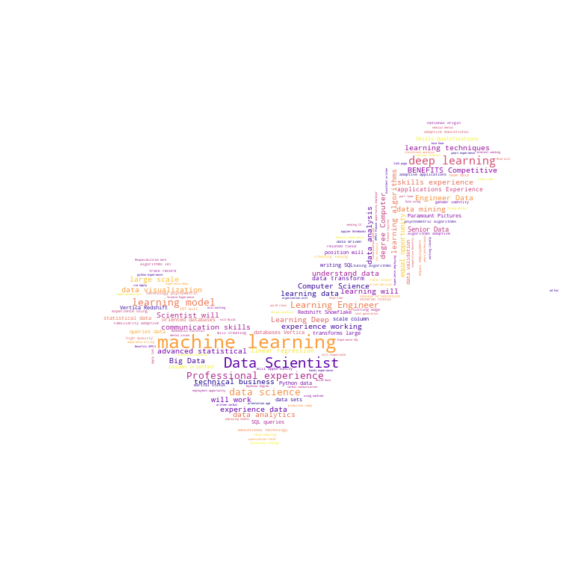

In [158]:
ds_text = ' '.join(desc for desc in ds_df.description)
stopwords = set(STOPWORDS)
ds_wc = WordCloud(background_color='white',
                  colormap='plasma',
                  width=800,
                  height=400,
                  mask=check_mask, 
                  stopwords=stopwords).generate(ds_text)

# save to file
ds_wc.to_file('ds_wordcloud.png')

plt.figure(figsize=(20, 10))
plt.imshow(ds_wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [154]:
x_mask = np.array(Image.open('../xmark.jpg'))


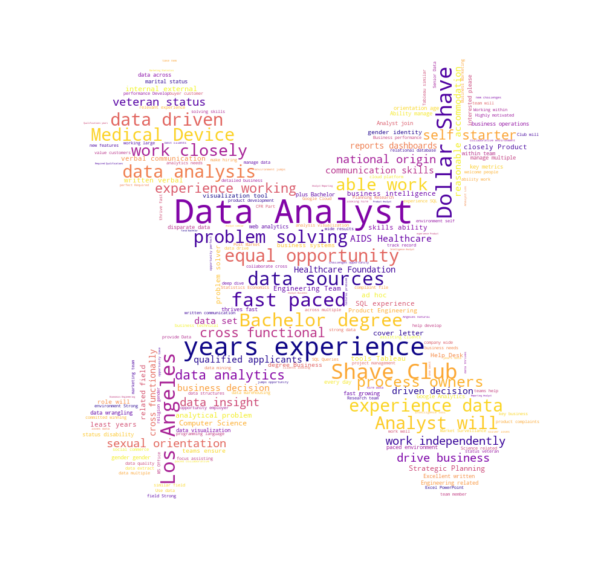

In [156]:
da_text = ' '.join(desc for desc in da_df.description)
stopwords = set(STOPWORDS)
da_wc = WordCloud(background_color='white',
                  colormap='plasma',
                  width=800,
                  height=400,
                  mask=x_mask,
                 ).generate(da_text)

# save to file
ds_wc.to_file('da_wordcloud.png')

plt.figure(figsize=(20, 10))
plt.imshow(da_wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [159]:
other_mask = np.array(Image.open('../qmark.jpg'))

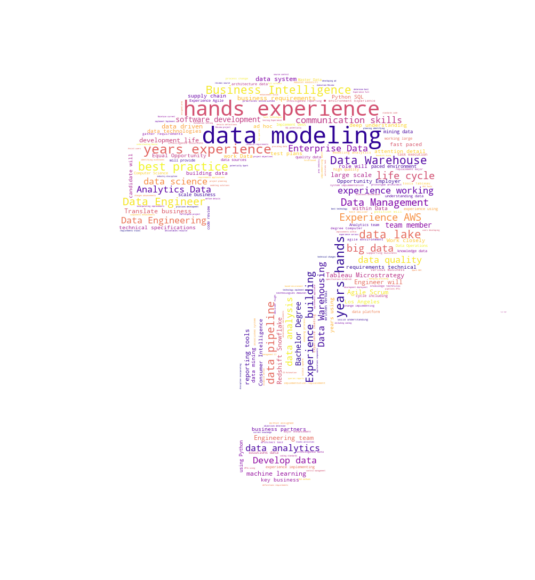

In [162]:
other_text = ' '.join(desc for desc in other_df.description)
stopwords = set(STOPWORDS)
other_wc = WordCloud(background_color='white',
                     colormap='plasma',
                     width=800,
                     height=400,
                     mask=other_mask,
                    ).generate(other_text)

# save to file
other_wc.to_file('other_wordcloud.png')

plt.figure(figsize=(20, 10))
plt.imshow(other_wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()